# St. Louis Fed API - FRED  
https://fredaccount.stlouisfed.org/

Install modules

In [2]:
import sys
# !{sys.executable} -m pip install 

Load modules

In [168]:
import os
import pandas as pd
import numpy as np
import json
import requests
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Set paths

In [8]:
base_path = os.path.join(os.path.expanduser('~'), 'bakery')
creds_path = os.path.join(base_path, 'fred/creds.json')

Load credential file

In [9]:
with open(creds_path, 'rb') as f:
    data = f.read()
    creds = json.loads(data)

### Explore API endpoints

Request Categories

In [13]:
endpoint = 'https://api.stlouisfed.org/fred/category'
params = {
    'api_key' : creds['api_key'], 
    'file_type': 'json',
    'category_id': 1
}

r = requests.get(endpoint, params=params)

In [14]:
r.json()

{'categories': [{'id': 1,
   'name': 'Production & Business Activity',
   'parent_id': 0}]}

Request tags

In [87]:
endpoint = 'https://api.stlouisfed.org/fred/tags'
params = {
    'api_key' : creds['api_key'], 
    'file_type': 'json'
}

r = requests.get(endpoint, params=params)

tags_df = pd.DataFrame(r.json()['tags'])

count = r.json()['count']
print(f'{count} total tags')
offset = r.json()['offset']
limit = r.json()['limit']

if limit <= count:
    offset += limit + 1
    remaining = count - limit
    while remaining > 0:
        print(f'{remaining} remaining tags')
        params['offset'] = offset
        r = requests.get(endpoint, params=params)
        tmp_df = pd.DataFrame(r.json()['tags'])
        tags_df = pd.concat([tags_df, tmp_df])
        remaining -= limit
        offset += limit + 1

5960 total tags
4960 remaining tags
3960 remaining tags
2960 remaining tags
1960 remaining tags
960 remaining tags


In [88]:
tags_df.head()

,name,group_id,notes,created,popularity,series_count
0,nsa,seas,Not Seasonally Adjusted,2012-02-27 10:18:19-06,99,735240
1,usa,geo,United States of America,2012-02-27 10:18:19-06,100,654300
2,public domain: citation requested,cc,None,2018-12-17 23:33:13-06,99,607978
3,annual,freq,,2012-02-27 10:18:19-06,88,490370
4,county,geot,County or County Equivalent,2012-02-27 10:18:19-06,77,331488


In [89]:
tags_df.shape

(5906, 6)

In [138]:
tags = list(tags_df['name'])

Get series related to tag

In [124]:
endpoint = 'https://api.stlouisfed.org/fred/tags/series'
params = {
    'api_key' : creds['api_key'], 
    'file_type': 'json',
    'tag_names': 'mei;usa;monthly;ppi'
}

r = requests.get(endpoint, params=params)

usa_mei_df = pd.DataFrame(r.json()['seriess'])

count = r.json()['count']
print(f'{count} total series for tags {params["tag_names"]}')
offset = r.json()['offset']
limit = r.json()['limit']

if limit <= count:
    offset += limit
    remaining = count - limit
    while remaining > 0:
        params['offset'] = offset
        r = requests.get(endpoint, params=params)
        tmp_df = pd.DataFrame(r.json()['seriess'])
        usa_mei_df = pd.concat([usa_mei_df, tmp_df])
        remaining -= limit

14 total series for tags mei;usa;monthly;ppi


In [125]:
usa_mei_df.shape

(14, 16)

In [126]:
dt_cols = ['realtime_start', 'realtime_end', 'observation_start', 'observation_end']

usa_mei_df.loc[:, dt_cols] = usa_mei_df.loc[:, dt_cols].apply(pd.to_datetime, errors='coerce')
usa_mei_df['last_updated'] = pd.to_datetime(usa_mei_df['last_updated'], utc=True)

In [129]:
usa_mei_df.sort_values(by='popularity', ascending=False)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,group_popularity,notes
4,PIEAMP02USM659N,2022-09-15,2022-09-15,Producer Prices Index: Economic Activities: Do...,1960-01-01,2022-07-01,Monthly,M,Growth Rate Same Period Previous Year,Growth Rate Same Period Previous Yr.,Not Seasonally Adjusted,NSA,2022-09-14 19:44:15+00:00,14,17,OECD descriptor ID: PIEAMP02\nOECD unit ID: GY...
10,PITGIG01USM661N,2022-09-15,2022-09-15,Producer Prices Index: Total Intermediate Good...,1974-01-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 19:44:18+00:00,14,15,OECD descriptor ID: PITGIG01\nOECD unit ID: IX...
9,PITGCG01USM661N,2022-09-15,2022-09-15,Producer Prices Index: Total Consumer Goods fo...,1960-01-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 19:44:21+00:00,11,22,OECD descriptor ID: PITGCG01\nOECD unit ID: IX...
0,PIEAEN01USM661N,2022-09-15,2022-09-15,Producer Prices Index: Economic Activities: To...,1960-01-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 19:44:41+00:00,7,7,OECD descriptor ID: PIEAEN01\nOECD unit ID: IX...
13,USAPPDMMINMEI,2022-09-15,2022-09-15,Domestic Producer Prices Index: Manufacturing ...,1960-01-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 19:44:45+00:00,4,8,"Copyright, 2016, OECD. Reprinted with permissi..."
3,PIEAMP01USM661N,2022-09-15,2022-09-15,Producer Prices Index: Economic Activities: To...,1960-01-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 19:44:37+00:00,2,5,OECD descriptor ID: PIEAMP01\nOECD unit ID: IX...
5,PISPFG01USM661N,2022-09-15,2022-09-15,Producer Prices Index: Stage of Processing: To...,1960-01-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 19:44:56+00:00,2,2,OECD descriptor ID: PISPFG01\nOECD unit ID: IX...
1,PIEAFD01USM661N,2022-09-15,2022-09-15,Producer Prices Index: Economic Activities: To...,1984-12-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 20:11:13+00:00,1,1,OECD descriptor ID: PIEAFD01\nOECD unit ID: IX...
2,PIEAMI01USM661N,2022-09-15,2022-09-15,Producer Prices Index: Economic Activities: To...,1984-12-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 20:11:13+00:00,1,1,OECD descriptor ID: PIEAMI01\nOECD unit ID: IX...
6,PISPIG01USM661N,2022-09-15,2022-09-15,Producer Prices Index: Stage of Processing: To...,1974-01-01,2022-07-01,Monthly,M,Index 2015=100,Index 2015=100,Not Seasonally Adjusted,NSA,2022-09-14 20:11:13+00:00,1,1,OECD descriptor ID: PISPIG01\nOECD unit ID: IX...


Get series (US Consumer Prices Index)

In [113]:
endpoint = 'https://api.stlouisfed.org/fred/series/observations'
params = {
    'api_key' : creds['api_key'], 
    'file_type': 'json',
    'series_id': 'USACPIALLMINMEI'
}

r = requests.get(endpoint, params=params)

In [120]:
us_cpi_df = pd.DataFrame(r.json()['observations'])

In [123]:
us_cpi_df = us_cpi_df.loc[
        us_cpi_df['value'] != '.',
        :
    ]

Get series (US Producer Prices Index)

In [130]:
endpoint = 'https://api.stlouisfed.org/fred/series/observations'
params = {
    'api_key' : creds['api_key'], 
    'file_type': 'json',
    'series_id': 'PPIACO'
}

r = requests.get(endpoint, params=params)

In [132]:
us_ppi_df = pd.DataFrame(r.json()['observations'])

In [133]:
us_ppi_df

,realtime_start,realtime_end,date,value
0,2022-09-15,2022-09-15,1913-01-01,12.1
1,2022-09-15,2022-09-15,1913-02-01,12.0
2,2022-09-15,2022-09-15,1913-03-01,12.0
3,2022-09-15,2022-09-15,1913-04-01,12.0
4,2022-09-15,2022-09-15,1913-05-01,11.9
...,...,...,...,...
1311,2022-09-15,2022-09-15,2022-04-01,265.310
1312,2022-09-15,2022-09-15,2022-05-01,273.256
1313,2022-09-15,2022-09-15,2022-06-01,280.220
1314,2022-09-15,2022-09-15,2022-07-01,272.082


Get series (GDP)

In [134]:
endpoint = 'https://api.stlouisfed.org/fred/series/observations'
params = {
    'api_key' : creds['api_key'], 
    'file_type': 'json',
    'series_id': 'GDP'
}

r = requests.get(endpoint, params=params)

In [136]:
us_gdp_df = pd.DataFrame(r.json()['observations'])
us_gdp_df = us_gdp_df.loc[
        us_gdp_df['value'] != '.',
        :
    ]

In [137]:
us_gdp_df

,realtime_start,realtime_end,date,value
4,2022-09-15,2022-09-15,1947-01-01,243.164
5,2022-09-15,2022-09-15,1947-04-01,245.968
6,2022-09-15,2022-09-15,1947-07-01,249.585
7,2022-09-15,2022-09-15,1947-10-01,259.745
8,2022-09-15,2022-09-15,1948-01-01,265.742
...,...,...,...,...
301,2022-09-15,2022-09-15,2021-04-01,22740.959
302,2022-09-15,2022-09-15,2021-07-01,23202.344
303,2022-09-15,2022-09-15,2021-10-01,24002.815
304,2022-09-15,2022-09-15,2022-01-01,24386.734


Get series (Unemployment Rate)

In [139]:
endpoint = 'https://api.stlouisfed.org/fred/series/observations'
params = {
    'api_key' : creds['api_key'], 
    'file_type': 'json',
    'series_id': 'UNRATE'
}

r = requests.get(endpoint, params=params)

In [142]:
us_unemp_df = pd.DataFrame(r.json()['observations'])

In [143]:
us_unemp_df

,realtime_start,realtime_end,date,value
0,2022-09-15,2022-09-15,1948-01-01,3.4
1,2022-09-15,2022-09-15,1948-02-01,3.8
2,2022-09-15,2022-09-15,1948-03-01,4.0
3,2022-09-15,2022-09-15,1948-04-01,3.9
4,2022-09-15,2022-09-15,1948-05-01,3.5
...,...,...,...,...
891,2022-09-15,2022-09-15,2022-04-01,3.6
892,2022-09-15,2022-09-15,2022-05-01,3.6
893,2022-09-15,2022-09-15,2022-06-01,3.6
894,2022-09-15,2022-09-15,2022-07-01,3.5


In [162]:
series_dict = {
    'quarterly': {
        'gross_domestic_product': 'GDP'
    },
    'monthly': {
        'consumer_price_index': 'CPIAUCSL',
        'sticky_consumer_price_index': 'CORESTICKM159SFRBATL',
        'producer_price_index': 'PPIACO',
        'industrial_production': 'INDPRO',
        'capacity_utilization': 'TCU',
        'personal_consumption_expenditures': 'PCE',
        'new_houses_sold': 'HSN1F',
        'new_houses_started': 'HOUST',
        'fed_funds_rate': 'FEDFUNDS',
        'uncertaintly_index': 'USEPUINDXM'
    }
}   

In [178]:
endpoint = 'https://api.stlouisfed.org/fred/series/observations'
df_ls = []

for series in series_dict['monthly']:
    id = series_dict['monthly'][series]
    
    params = {
        'api_key' : creds['api_key'], 
        'file_type': 'json',
        'series_id': id
    }
    
    r = requests.get(endpoint, params=params)
    
    df = pd.DataFrame(r.json()['observations']).loc[:, ['date', 'value']] \
        .rename(columns={'value': series})
    
    df['date'] = pd.to_datetime(df['date'])
    df[series] = df[series].astype('double')
    
    df_ls.append(df)

In [179]:
df_merged = reduce(
    lambda left,right: pd.merge(left, right, on=['date'], how='outer'), 
    df_ls
)

In [180]:
df_merged.sort_values(by='date')

,date,consumer_price_index,sticky_consumer_price_index,producer_price_index,industrial_production,capacity_utilization,personal_consumption_expenditures,new_houses_sold,new_houses_started,fed_funds_rate,uncertaintly_index
908,1913-01-01,NaN,NaN,12.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
909,1913-02-01,NaN,NaN,12.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
910,1913-03-01,NaN,NaN,12.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
911,1913-04-01,NaN,NaN,12.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
912,1913-05-01,NaN,NaN,11.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
903,2022-04-01,288.663,4.723538,265.310,104.2577,80.2183,16904.9,619.0,1805.0,0.33,154.66196
904,2022-05-01,291.474,4.975575,273.256,104.1868,80.0369,16991.6,630.0,1562.0,0.77,168.00082
905,2022-06-01,295.328,5.425963,280.220,104.1778,79.9055,17160.6,585.0,1599.0,1.21,145.97592
906,2022-07-01,295.271,5.629465,272.082,104.7189,80.2024,17184.3,511.0,1446.0,1.68,186.94206


In [181]:
df_merged_melt = pd.melt(
    df_merged,
    id_vars=['date'],
    value_vars=['consumer_price_index', 'sticky_consumer_price_index', 'producer_price_index', 'industrial_production', 'capacity_utilization', 'personal_consumption_expenditures', 'new_houses_sold', 'new_houses_started', 'fed_funds_rate', 'uncertaintly_index'],
    var_name='series', value_name='value'
)

In [184]:
df_merged_melt.tail()

,date,series,value
13155,1946-08-01,uncertaintly_index,NaN
13156,1946-09-01,uncertaintly_index,NaN
13157,1946-10-01,uncertaintly_index,NaN
13158,1946-11-01,uncertaintly_index,NaN
13159,1946-12-01,uncertaintly_index,NaN


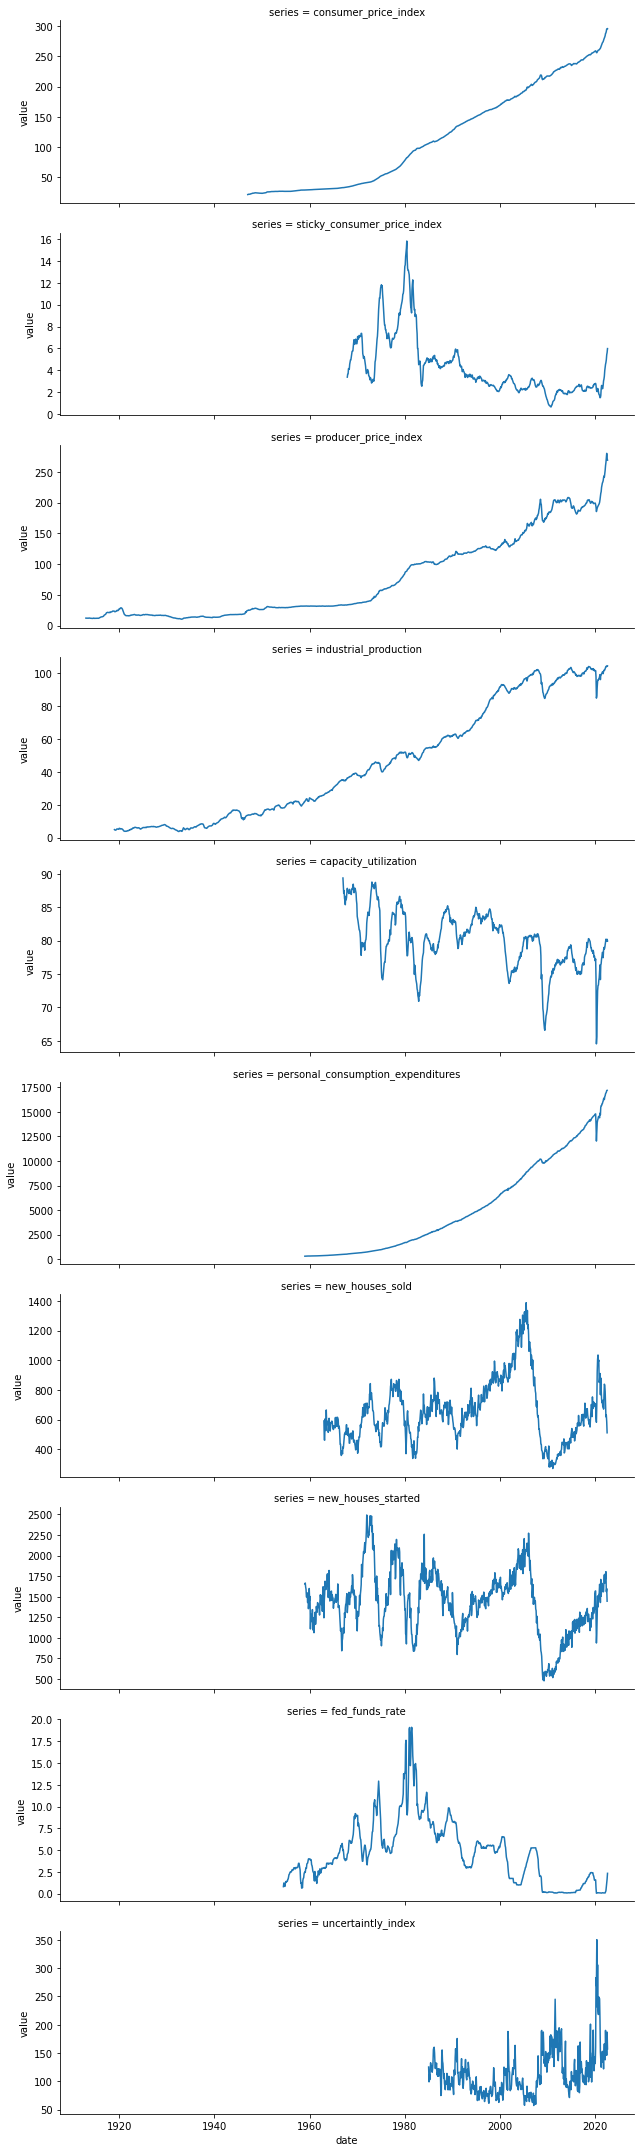

In [186]:
sns.relplot(
    data=df_merged_melt,
    x='date', y='value',
    col='series', height=3, aspect=3, 
    col_wrap=1, kind='line',
    facet_kws={'sharey': False}
)